In [13]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import itertools
from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from skbio.stats.composition import ilr, clr
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.stats import chi2

from statsmodels.stats.multitest import fdrcorrection

from src.models.outliers import outlier_detection, logratio_outlier_detection, impute_zero_values
from src.visualization.plots import biplot, screeplot, loadingsplot, psuedocontrolcomparisonplot
from src.config import get_interim_dir, get_experiment_artifacts
from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, TARGETDIFF, SAMPLE, PAIRED_SAMPLES, PROFILE_TYPE


In [15]:
HOME_PATH, FILTER_COUNT, METHOD, TARGETDIFF, SAMPLE

('/Users/colm', 700, 'robust_cov', 'targetdiff', 'sample')

In [16]:
aliases = ["MB0{}".format(i) for i in range(1, 7)]
X_imputed = pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))

In [17]:
pseudo_controls = pd.read_csv(get_experiment_artifacts(profile_type=SAMPLE) + "psuedo_controls.txt")["0"]

In [18]:
if PROFILE_TYPE == PAIRED_SAMPLES:   
    def calculate_differential_profile(alias1, alias2, X_imputed, pseudo_controls):
        print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias1))
        print("There are {} genes in {}".format(X_imputed[alias1].shape[0], alias2))
        a = X_imputed[alias1]
        b = X_imputed[alias2]
        
        X = pd.concat([a, b], axis=0)
        columns = X.columns
        X = X.groupby(["Gene"]).apply(stats.gmean)
        X = pd.DataFrame(X.values.tolist(), index=X.index, columns=columns)
        X = X.div(X.sum(axis=1), axis=0)

        Z_case = X
        print("There are {} cases".format(Z_case.shape[0]))

        return Z_case

        # Z_control = X.loc[pseudo_controls, :]
        # print("There are {} controls".format(Z_control.shape[0]))

        # columns = Z_control.columns
        # Z_control_mean = Z_control.apply(stats.gmean)
        # Z_control_mean = pd.Series(Z_control_mean.values.tolist(), index=columns)
        # Z_control_mean = Z_control_mean.div(Z_control_mean.sum())

        # Z_case_diff = np.log2(Z_case/Z_control_mean)
        # return Z_case_diff
        # Z_case_diff = Z_case - Z_control_mean
        # return Z_case_diff

    Z = {}

    Z["T1"] = calculate_differential_profile("MB01", "MB02", X_imputed, pseudo_controls)
    Z["T2"] = calculate_differential_profile("MB03", "MB04", X_imputed, pseudo_controls)
    Z["T3"] = calculate_differential_profile("MB05", "MB06", X_imputed, pseudo_controls)

    print(Z["T1"].shape[0], Z["T2"].shape[0], Z["T3"].shape[0])

There are 16432 genes in MB01
There are 16432 genes in MB02
There are 16432 cases
There are 17943 genes in MB03
There are 17943 genes in MB04
There are 17943 cases
There are 18025 genes in MB05
There are 18025 genes in MB06
There are 18025 cases
16432 17943 18025


In [19]:
if PROFILE_TYPE == TARGETDIFF:
    def calculate_differential_profile(X_imputed, pseudo_controls):
        print("There are {} genes".format(X_imputed.shape[0]))

        Z_control = X_imputed.loc[pseudo_controls, :]
        print("There are {} controls".format(Z_control.shape[0]))

        Z_case = X_imputed
        print("There are {} cases".format(Z_case.shape[0]))

        columns = Z_control.columns
        Z_control_mean = Z_control.apply(stats.gmean)
        Z_control_mean = pd.Series(Z_control_mean.values.tolist(), index=columns)
        Z_control_mean = Z_control_mean.div(Z_control_mean.sum())
        Z_case_diff = np.log2(Z_case/Z_control_mean)
        # Z_case_diff = Z_case - Z_control_mean
        return Z_case_diff


    def calculate_mean_differential_profile(alias1, alias2, X_imputed, pseudo_controls):
        print("Calculating differential profile for aliases {} and {}".format(alias1, alias2))
        a = calculate_differential_profile(X_imputed[alias1], pseudo_controls)
        b = calculate_differential_profile(X_imputed[alias2], pseudo_controls)
        c = pd.concat([a, b], axis=0).groupby("Gene", axis=0).min()
        return c

    Z = {}

    Z["T1"] = calculate_mean_differential_profile("MB01", "MB02", X_imputed, pseudo_controls)
    Z["T2"] = calculate_mean_differential_profile("MB03", "MB04", X_imputed, pseudo_controls)
    Z["T3"] = calculate_mean_differential_profile("MB05", "MB06", X_imputed, pseudo_controls)

    print(Z["T1"].shape[0], Z["T2"].shape[0], Z["T3"].shape[0])


[0.25411743 0.46215142 0.64110715 0.78606296 0.91029724 1.        ]


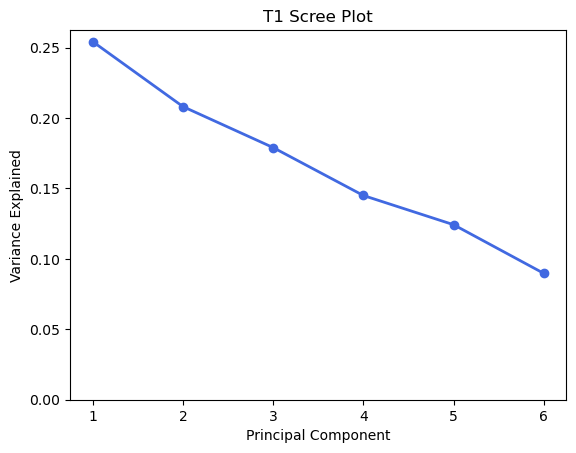

<Figure size 900x600 with 0 Axes>

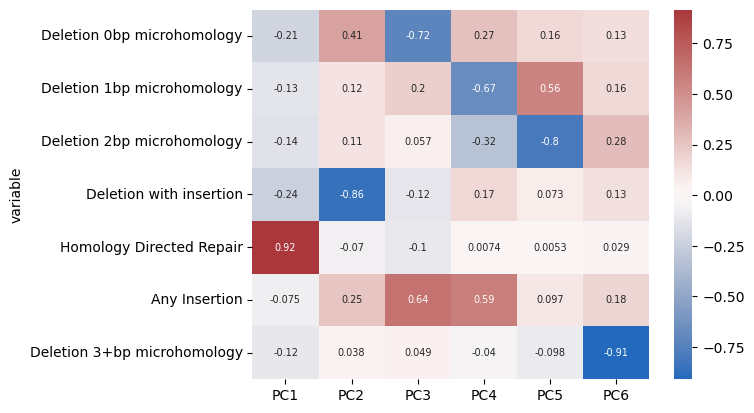

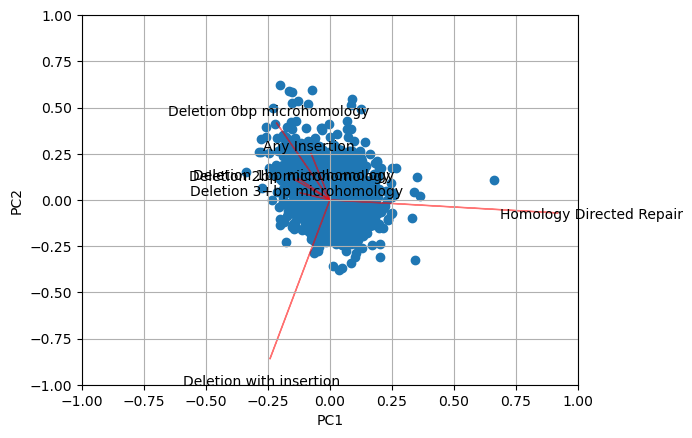

[0.27100468 0.51080064 0.68322485 0.82701308 0.92376925 1.        ]


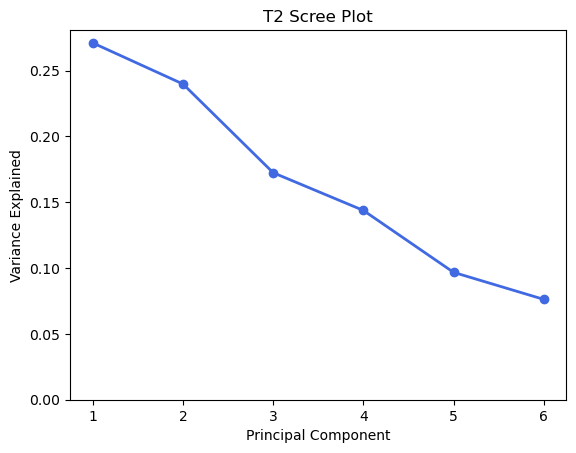

<Figure size 900x600 with 0 Axes>

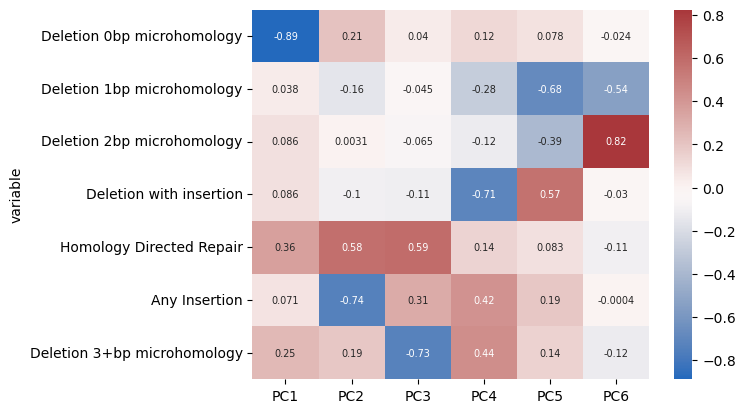

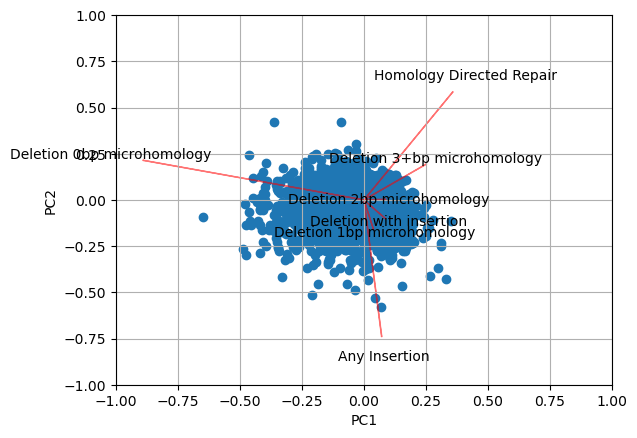

[0.39164551 0.58555577 0.74028992 0.86066087 0.93491703 1.        ]


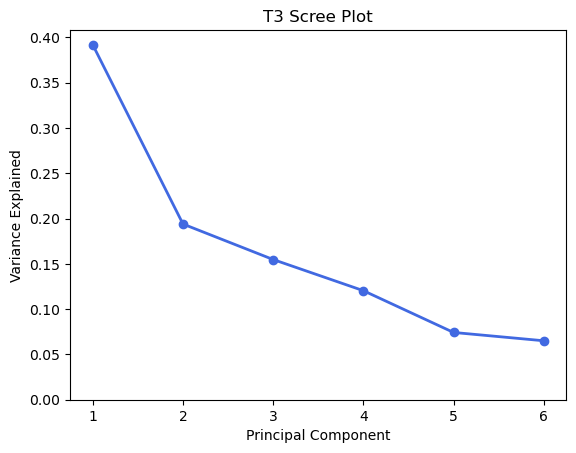

<Figure size 900x600 with 0 Axes>

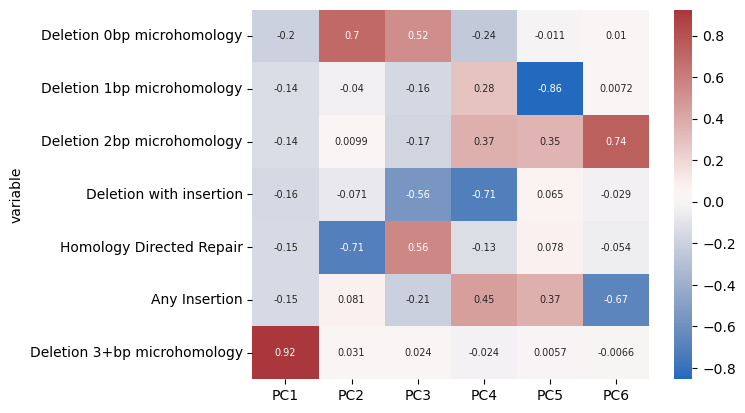

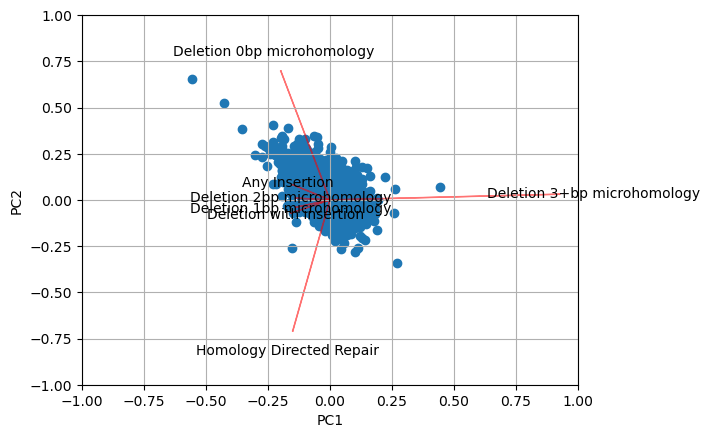

In [20]:
results = {}
for target in Z:
    if PROFILE_TYPE == PAIRED_SAMPLES:
        pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(Z[target], MinCovDet(random_state=1))
    elif PROFILE_TYPE == TARGETDIFF:
        pca_scores, loadings, explained_variance_ratio, distances, pvalues = outlier_detection(Z[target], MinCovDet(random_state=1))
    results[target] = pca_scores, loadings, explained_variance_ratio, distances, pvalues

    print(np.cumsum(explained_variance_ratio))

    fig, ax = plt.subplots()
    screeplot(explained_variance_ratio, ax, target)
    plt.savefig("{}/screeplot.{}.png".format(get_experiment_artifacts(profile_type=PROFILE_TYPE), target))
    plt.show()

    plt.figure(figsize=(9, 6))
    loadings_df, _ = loadingsplot(loadings, Z[target].columns.to_list())
    plt.savefig("{}/laodingsplot.{}.png".format(get_experiment_artifacts(profile_type=PROFILE_TYPE), target))
    plt.show()

    #Call the function. Use only the 2 PCs.
    pcs_to_analyse = [0, 1]
    biplot(pca_scores[:,pcs_to_analyse], loadings_df.iloc[:,pcs_to_analyse].values, labels=loadings_df.index, components=loadings_df.iloc[:,pcs_to_analyse].columns)
    plt.savefig("{}/biplot.{}.png".format(get_experiment_artifacts(profile_type=PROFILE_TYPE), target))
    plt.show()

In [21]:
pvalue_dfs = [pd.DataFrame({"pvalues": results[target][-1],
"distances": results[target][-2]}, index=Z[target].index) for target in Z.keys()]

# FDR correction, removed Thu 16 Feb. Can be applied later to the orignal p-values, do not rerun this code to get FDR correction. Only use final_gene_list.tsv spreadsheet
# for pvalue_df in pvalue_dfs:
#     corrected = fdrcorrection(pvalue_df["pvalues"], alpha=FDR_ALPHA)
#     pvalue_df["reject"] = corrected[0]
#     pvalue_df["pvals_corrected"] = corrected[1]

results_df = pd.concat(pvalue_dfs, axis=1, keys=Z.keys())
results_df.columns.names = ["Sample", "Measure"]
results_df.head()

Sample               T1                                          T2            \
Measure         pvalues  distances reject pvals_corrected   pvalues distances   
Gene                                                                            
0610009B22Rik  0.999409   0.169394  False        0.999469  0.733467  2.782549   
0610010K14Rik  0.922053   1.420544  False        0.961674  0.731721  2.793915   
0610030E20Rik  0.151195   8.092794  False        0.424183  0.684153  3.102720   
0610040J01Rik  0.027328  12.609331  False        0.140374  0.233254  6.834351   
1110004F10Rik  0.096137   9.343101  False        0.322913  0.283318  6.242655   

Sample                                      T3                    \
Measure       reject pvals_corrected   pvalues  distances reject   
Gene                                                               
0610009B22Rik  False        0.886617  0.285361   6.220391  False   
0610010K14Rik  False        0.885916  0.719884   2.870883  False   
0610030E20Rik  False        0.862395  0.582823   3.771077  False   
0610040J01Rik  False        0.546524  0.011091  14.835082  False   
1110004F10Rik  False        0.595443  0.048631  11.142245  False   

Sample                         
Measure       pvals_corrected  
Gene                           
0610009B22Rik        0.590030  
0610010K14Rik        0.875213  
0610030E20Rik        0.806202  
0610040J01Rik        0.071550  
1110004F10Rik        0.206206

In [22]:
# alpha=0.1
# pvals = results_df[("T1", "pvalues")].dropna()
# pvals = np.asarray(pvals)
# pvals_sortind = np.argsort(pvals)
# pvals_sorted = np.take(pvals, pvals_sortind)
# nobs = len(pvals_sorted)
# ecdffactor = np.arange(1,nobs+1)/float(nobs)
# reject = pvals_sorted <= ecdffactor*alpha
# if reject.any():
#     rejectmax = max(np.nonzero(reject)[0])
#     reject[:rejectmax] = True
# pvals_corrected_raw = pvals_sorted / ecdffactor


In [23]:
# score_df = results_df[(results_df.xs("reject", level="Measure", axis=1).fillna(False).any(axis=1))]
# score_df = pd.DataFrame(StandardScaler().fit_transform(score_df.xs("distances", level="Measure", axis=1)), columns=score_df.columns.unique(level=0), index=score_df.index)
# score_df.loc[:,"Mean Score"] = score_df.mean(axis=1)
# print("There are {} outlying gene profiles".format(score_df.shape[0]))

# score_df = score_df.sort_values("Mean Score", ascending=False)

There are 4564 outlying gene profiles


In [26]:
results_df.dropna()

Sample               T1                                          T2  \
Measure         pvalues  distances reject pvals_corrected   pvalues   
Gene                                                                  
0610009B22Rik  0.999409   0.169394  False        0.999469  0.733467   
0610010K14Rik  0.922053   1.420544  False        0.961674  0.731721   
0610030E20Rik  0.151195   8.092794  False        0.424183  0.684153   
0610040J01Rik  0.027328  12.609331  False        0.140374  0.233254   
1110004F10Rik  0.096137   9.343101  False        0.322913  0.283318   
...                 ...        ...    ...             ...       ...   
Zzef1          0.061736  10.521542  False        0.241824  0.618102   
Zzz3           0.057719  10.697499  False        0.231734  0.325212   
a              0.299143   6.073391  False        0.608733  0.064665   
ccdc198        0.693403   3.042695  False        0.870757  0.063480   
mei-04         0.000198  24.210929   True        0.002954  0.110368   

Sample                                                 T3                    \
Measure        distances reject pvals_corrected   pvalues  distances reject   
Gene                                                                          
0610009B22Rik   2.782549  False        0.886617  0.285361   6.220391  False   
0610010K14Rik   2.793915  False        0.885916  0.719884   2.870883  False   
0610030E20Rik   3.102720  False        0.862395  0.582823   3.771077  False   
0610040J01Rik   6.834351  False        0.546524  0.011091  14.835082  False   
1110004F10Rik   6.242655  False        0.595443  0.048631  11.142245  False   
...                  ...    ...             ...       ...        ...    ...   
Zzef1           3.534976  False        0.828647  0.049645  11.088948  False   
Zzz3            5.809376  False        0.635928  0.516723   4.230547  False   
a              10.399931  False        0.261265  0.572931   3.838254  False   
ccdc198        10.448512  False        0.257892  0.253634   6.581941  False   
mei-04          8.967481  False        0.363298  0.686614   3.086748  False   

Sample                         
Measure       pvals_corrected  
Gene                           
0610009B22Rik        0.590030  
0610010K14Rik        0.875213  
0610030E20Rik        0.806202  
0610040J01Rik        0.071550  
1110004F10Rik        0.206206  
...                       ...  
Zzef1                0.209223  
Zzz3                 0.765259  
a                    0.801231  
ccdc198              0.558143  
mei-04               0.857203  

[16244 rows x 12 columns]

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


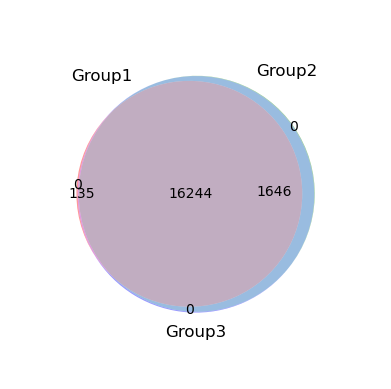

In [36]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

set1 = set(results_df["T1"].dropna().index.to_list())
set2 = set(results_df["T2"].dropna().index.to_list())
set3 = set(results_df["T3"].dropna().index.to_list())

venn3([set1, set2, set3], ('Group1', 'Group2', 'Group3'), normalize_to=.1)

plt.show()

In [24]:
results_df.to_pickle(get_experiment_artifacts(profile_type=PROFILE_TYPE) + "outlier_results.pkl")
pkl.dump(Z, open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=PROFILE_TYPE)), "wb"))